# Mean-state differences in the sensitivity experiments

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from tqdm.notebook import tqdm

In [3]:
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [4]:
from adjustText import adjust_text

In [5]:
import iris.plot as iplt
from iris.analysis.maths import apply_ufunc

In [6]:
import iris.quickplot as qplt
from ipywidgets import interact

In [7]:
# My packages and local scripts
import aeolus

print(aeolus.__version__)
from aeolus.calc import (
    abs_coord_mean,
    bond_albedo,
    integrate,
    meridional_mean,
    region_mean_diff,
    spatial,
    spatial_mean,
    time_mean,
    vertical_mean,
    water_path,
    zonal_mean,
)
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import get_cube_rel_days
from aeolus.core import AtmoSim
from aeolus.io import load_data, save_cubelist
from aeolus.meta import const_from_attrs, preserve_shape, update_metadata
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    fmt_lonlat,
    label_global_map_gridlines,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.subset import DimConstr, extract_last_n_days, l_range_constr

0.4.13+22.g6e7cfd9


In [8]:
from pouch.clim_diag import (
    bv_freq_sq,
    calc_derived_cubes,
    d_dphi,
    hgt_cnstr_0_1km,
    latent_heating_rate,
    latitude_of_max_zonal_wind,
    longitude_of_wave_crest,
    mean_dry_lapse_rate,
    moist_static_energy,
    ratio_of_dn_to_eq_pole_temp_diff,
    upper_atm_vap_mean,
    wind_rot_div,
)
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    figsave,
    linspace_pm1,
    use_style,
)

In [9]:
import mypaths
from commons import (
    DAYSIDE,
    GLM_SUITE_ID,
    NIGHTSIDE,
    OPT_LABELS,
    SIM_LABELS,
    as_lon,
    cold_traps,
    eq_lat,
    free_troposphere,
    mid_lat,
    midlatitudes,
    ss_lon,
    troposphere,
)

In [10]:
use_style()

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])

### Load all sensitivity experiments

In [11]:
img_prefix = f"{GLM_SUITE_ID}_mean"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

In [12]:
# Load processed data
sim_prop = SIM_LABELS["base"]
runs = {}
runs_p = {}
for sim_label, _ in tqdm(OPT_LABELS.items()):
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    if sim_label in ["base", "sens-llcs_all_rain", "sens-startswap"]:
        time_prof = "mean_days6000_9950"
    elif sim_label == "sens-noradcld":
        time_prof = "mean_days2000_2200"
    else:
        time_prof = "mean_days2000_2950"
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Use the cube list to initialise an AtmoSim object
    calc_derived_cubes(cl, const=const)
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
    )
    # Cubes on pressure levels
    cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    runs_p[sim_label] = AtmoSim(
        cl_p,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="p",
    )

  0%|          | 0/13 [00:00<?, ?it/s]

### Table with time-mean diagnostics

In [13]:
time_reduce = lambda cube: time_mean(cube, model=um)

In [14]:
P_LEV = 300  # hPa
p_lev_constr = iris.Constraint(**{um.pres: P_LEV * 1e2})

In [15]:
VRBL_PLOT = {
    "dtdz_0_1km": {
        "cube": lambda AS, model=um: spatial(
            mean_dry_lapse_rate(AS._cubes.extract(hgt_cnstr_0_1km), model=model), "mean"
        ),
        "title": "Lapse rate between 0 and 1 km",
        "short_title": r"$dT/dz$",
        "tex_units": "$K$ $km^{-1}$",
        "fmt": lambda x: f"{x:.1f}",
        "lim": [10, 25],
    },
    "up_atm_wv": {
        "cube": lambda AS: spatial(upper_atm_vap_mean(AS._cubes), "mean"),
        "title": "Specific humidity at 100 hPa",
        "short_title": r"$q_{100hPa}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: fr"\num{{{x:.1e}}}",
        "lim": [1e-8, 1e-6],
        "scale": "log",
    },
    "up_atm_wv_10hpa": {
        "cube": lambda AS: spatial(upper_atm_vap_mean(AS._cubes, levels=0.01), "mean"),
        "title": "Specific humidity at 10 hPa",
        "short_title": r"$q_{10hPa}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: fr"\num{{{x:.1e}}}",
        "lim": [5e-9, 1e-6],
        "scale": "log",
    },
    "up_atm_wv_term": {
        "cube": lambda AS: spatial(
            upper_atm_vap_mean(
                AS._cubes.extract(iris.Constraint(**{um.x: lambda x: x in [-90, 90]}))
            ),
            "mean",
        ),
        "title": "Specific humidity at 100 hPa\nat the terminators",
        "short_title": r"$q_{100hPa,term}$",
        "tex_units": "$kg$ $kg^{-1}$",
        "fmt": lambda x: fr"\num{{{x:.1e}}}",
        "lim": [1e-8, 1e-6],
        "scale": "log",
    },
    "b_alb_gm": {
        "cube": lambda AS: spatial(bond_albedo(AS._cubes), "mean"),
        "title": "Bond albedo",
        "short_title": r"$\alpha_b$",
        "tex_units": "1",
        "lim": [0, 0.5],
        "fmt": lambda x: f"{x:.2f}",
    },
    "t_sfc_cold_traps": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(cold_traps)),
        "title": "Surface temperature in cold traps",
        "short_title": "$T_{s,ct}$",
        "tex_units": "$K$",
        "lim": [160, 260],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_d": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(DAYSIDE.constraint)),
        "title": "Mean day-side surface temperature",
        "short_title": "$T_{s,d}$",
        "tex_units": "$K$",
        "lim": [240, 280],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_n": {
        "cube": lambda AS: spatial_mean(AS.t_sfc.extract(NIGHTSIDE.constraint)),
        "title": "Mean day-side surface temperature",
        "short_title": "$T_{s,n}$",
        "tex_units": "$K$",
        "lim": [195, 235],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_min": {
        "cube": lambda AS: spatial(AS.t_sfc, "min"),
        "title": "Minimum surface temperature",
        "short_title": "$T_{s,min}$",
        "tex_units": "$K$",
        "lim": [165, 220],
        "fmt": lambda x: f"{x:.1f}",
    },
    "t_sfc_max": {
        "cube": lambda AS: spatial(AS.t_sfc, "max"),
        "title": "Maximum surface temperature",
        "short_title": "$T_{s,max}$",
        "tex_units": "$K$",
        "lim": [280, 310],
        "fmt": lambda x: f"{x:.1f}",
    },
    "jet_lat_free_trop": {
        "cube": lambda AS: latitude_of_max_zonal_wind(AS.u.extract(free_troposphere)),
        "title": "Latitude of the tropospheric jet",
        "short_title": "$\phi_{u_{max}}$",
        "tex_units": "$\degree$",
        "lim": [0, 90],
        "ticks": [0, 30, 60, 90],
        "fmt": lambda x: f"{x:.1f}",
    },
    "ratio_dn_ep_temp_diff_trop": {
        "cube": lambda AS: ratio_of_dn_to_eq_pole_temp_diff(AS.extract(troposphere)),
        "title": "Ratio of the day-night to\nequator-pole temperature difference",
        "short_title": r"$\Delta T_{dn}/\Delta T_{ep}$",
        "tex_units": "1",
        "lim": [0, 1.5],
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_mean_eq_jet_{P_LEV}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "mean"),
        "title": f"Mean zonal wind at the equator at {P_LEV} hpa",
        "short_title": r"$\overline{u_{eq}}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [15, 55],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
    f"u_max_eq_jet_{P_LEV}hpa": {
        "source": "p",
        "cube": lambda AS: spatial(AS.u.extract(p_lev_constr & eq_lat), "max"),
        "title": f"Maximum zonal wind at the equator at {P_LEV} hpa",
        "short_title": r"$u_{eq,max}$",
        "tex_units": "$m$ $s^{-1}$",
        "lim": [0, 100],
        "source": "p",
        "fmt": lambda x: f"{x:.1f}",
    },
    "dtemp_dphi_tropmean": {
        "cube": lambda AS: spatial(
            -1
            * abs_coord_mean(
                zonal_mean(
                    d_dphi(
                        vertical_mean(
                            AS.temp.extract(troposphere),
                            weight_by=AS.dens.extract(troposphere),
                        )
                    )
                ),
                um.y,
            ),
            "max",
        ),
        "title": "Meridional gradient\nof the mean tropospheric\ntemperature",
        "short_title": r"$\overline{\Delta T_{ep}}$",
        "tex_units": "$K$ $(1000 km)^{-1}$",
        "lim": [0, 10],
        "ax": 0,
        "fmt": lambda x: f"{x:.1f}",
    },
    "dt_lh_dayside_eq": {
        "cube": lambda AS: time_reduce(
            spatial_mean(
                vertical_mean(
                    latent_heating_rate(AS._cubes), weight_by=AS.dens
                ).extract(DAYSIDE.constraint & eq_lat)
            )
        ),
        "tex_units": "$K$ $day^{-1}$",
        "title": "Dayside latent heating",
        "short_title": r"$(\partial T/\partial t)_{lh}$",
        "lim": [0, 6],
        "fmt": lambda x: f"{x:.1f}",
    },
}

In [16]:
RESULTS = {}
for vrbl_key, vrbl_prop in tqdm(VRBL_PLOT.items()):
    RESULTS[vrbl_key] = {}
    for sim_label in tqdm(OPT_LABELS.keys(), leave=False):
        if vrbl_prop.get("source", "") == "p":
            the_run = runs_p[sim_label]
        else:
            the_run = runs[sim_label]

        # Calculate diagnostics
        cube = time_reduce(vrbl_prop["cube"](the_run))
        try:
            cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        except ValueError:
            pass
        RESULTS[vrbl_key][sim_label] = cube

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [17]:
dfs = {}
for sim_label, sim_prop in OPT_LABELS.items():
    _data = {}
    for vrbl_key, vrbl_prop in VRBL_PLOT.items():
        _data[vrbl_prop["short_title"]] = float(RESULTS[vrbl_key][sim_label].data)
    dfs[sim_label] = pd.DataFrame(
        _data,
        index=pd.Index(name="Experiment", data=[sim_prop["title"]]),
    )

In [18]:
df = pd.concat(dfs, axis="index").droplevel(0)

formatters = {
    k: {j["short_title"]: j["fmt"] for j in VRBL_PLOT.values()}[k] for k in df.columns
}

# df.columns = [fr"\colhead{{{i}}}" for i in df.columns]
print(
    df.to_latex(
        formatters=formatters,
        column_format="l" + "c" * len(VRBL_PLOT),
        escape=False,
    )
)

\begin{tabular}{lcccccccccccccccc}
\toprule
{} & $dT/dz$ &  $q_{100hPa}$ &   $q_{10hPa}$ & $q_{100hPa,term}$ & $\alpha_b$ & $T_{s,ct}$ & $T_{s,d}$ & $T_{s,n}$ & $T_{s,min}$ & $T_{s,max}$ & $\phi_{u_{max}}$ & $\Delta T_{dn}/\Delta T_{ep}$ & $\overline{u_{eq}}$ & $u_{eq,max}$ & $\overline{\Delta T_{ep}}$ & $(\partial T/\partial t)_{lh}$ \\
Experiment   &         &               &               &                   &            &            &           &           &             &             &                  &                               &                     &              &                            &                                \\
\midrule
Base         &    22.2 & \num{7.1e-07} & \num{1.8e-07} &     \num{7.2e-07} &       0.31 &      171.0 &     259.4 &     200.9 &       169.1 &       288.1 &             28.0 &                           0.9 &                40.3 &         82.6 &                        2.6 &                            0.5 \\
Adjust       &    16.1 & \num{8.8e-08} 

In [91]:
# KW_PLT_GROUPS = {
#     "base": {"title": "Base", "kw_plt": dict(color="C0")},
#     "t": {"title": "T0", "kw_plt": dict(color="C1")},
#     "start": {"title": "Start", "kw_plt": dict(color="C2")},
#     "hcapsea": {"title": "SOD", "kw_plt": dict(color="C3")},
#     "sst": {"title": "FixedSST", "kw_plt": dict(color="C4")},
#     "conv": {"title": "Adjust", "kw_plt": dict(color="C5")},
#     "rad": {"title": "CRE_off", "kw_plt": dict(color="C6")},
# }

KW_PLT_GROUPS = {
    "base": {"title": "Base", "kw_plt": dict(marker="o")},
    "t": {"title": "T0", "kw_plt": dict(marker="*")},
    "start": {"title": "Start", "kw_plt": dict(marker=".")},
    "hcapsea": {"title": "SOD", "kw_plt": dict(marker="X")},
    "sst": {"title": "FixedSST", "kw_plt": dict(marker="P")},
    "conv": {"title": "Adjust", "kw_plt": dict(marker="D")},
    "rad": {"title": "CRE_off", "kw_plt": dict(marker="p")},
}

In [92]:
REGIMES = {
    "EJ": {"kw_plt": {"color": "C0"}},
    "MJ": {"kw_plt": {"color": "C1"}},
}

In [93]:
VRBL_PLOT.keys()

dict_keys(['dtdz_0_1km', 'up_atm_wv', 'up_atm_wv_10hpa', 'up_atm_wv_term', 'b_alb_gm', 't_sfc_cold_traps', 't_sfc_d', 't_sfc_n', 't_sfc_min', 't_sfc_max', 'jet_lat_free_trop', 'ratio_dn_ep_temp_diff_trop', 'u_mean_eq_jet_300hpa', 'u_max_eq_jet_300hpa', 'dtemp_dphi_tropmean', 'dt_lh_dayside_eq'])

In [95]:
# vrbl_key_x = "jet_lat_free_trop"
# vrbl_key_y = "ratio_dn_ep_temp_diff_trop"

In [102]:
vrbl_pairs = [["u_max_eq_jet_300hpa", "jet_lat_free_trop"], ["ratio_dn_ep_temp_diff_trop", "t_sfc_cold_traps"]]

Saved to ../plots/ch111_mean/ch111_mean__all_sim__u_max_eq_jet_300hpa_jet_lat_free_trop_ratio_dn_ep_temp_diff_trop_t_sfc_cold_traps.png


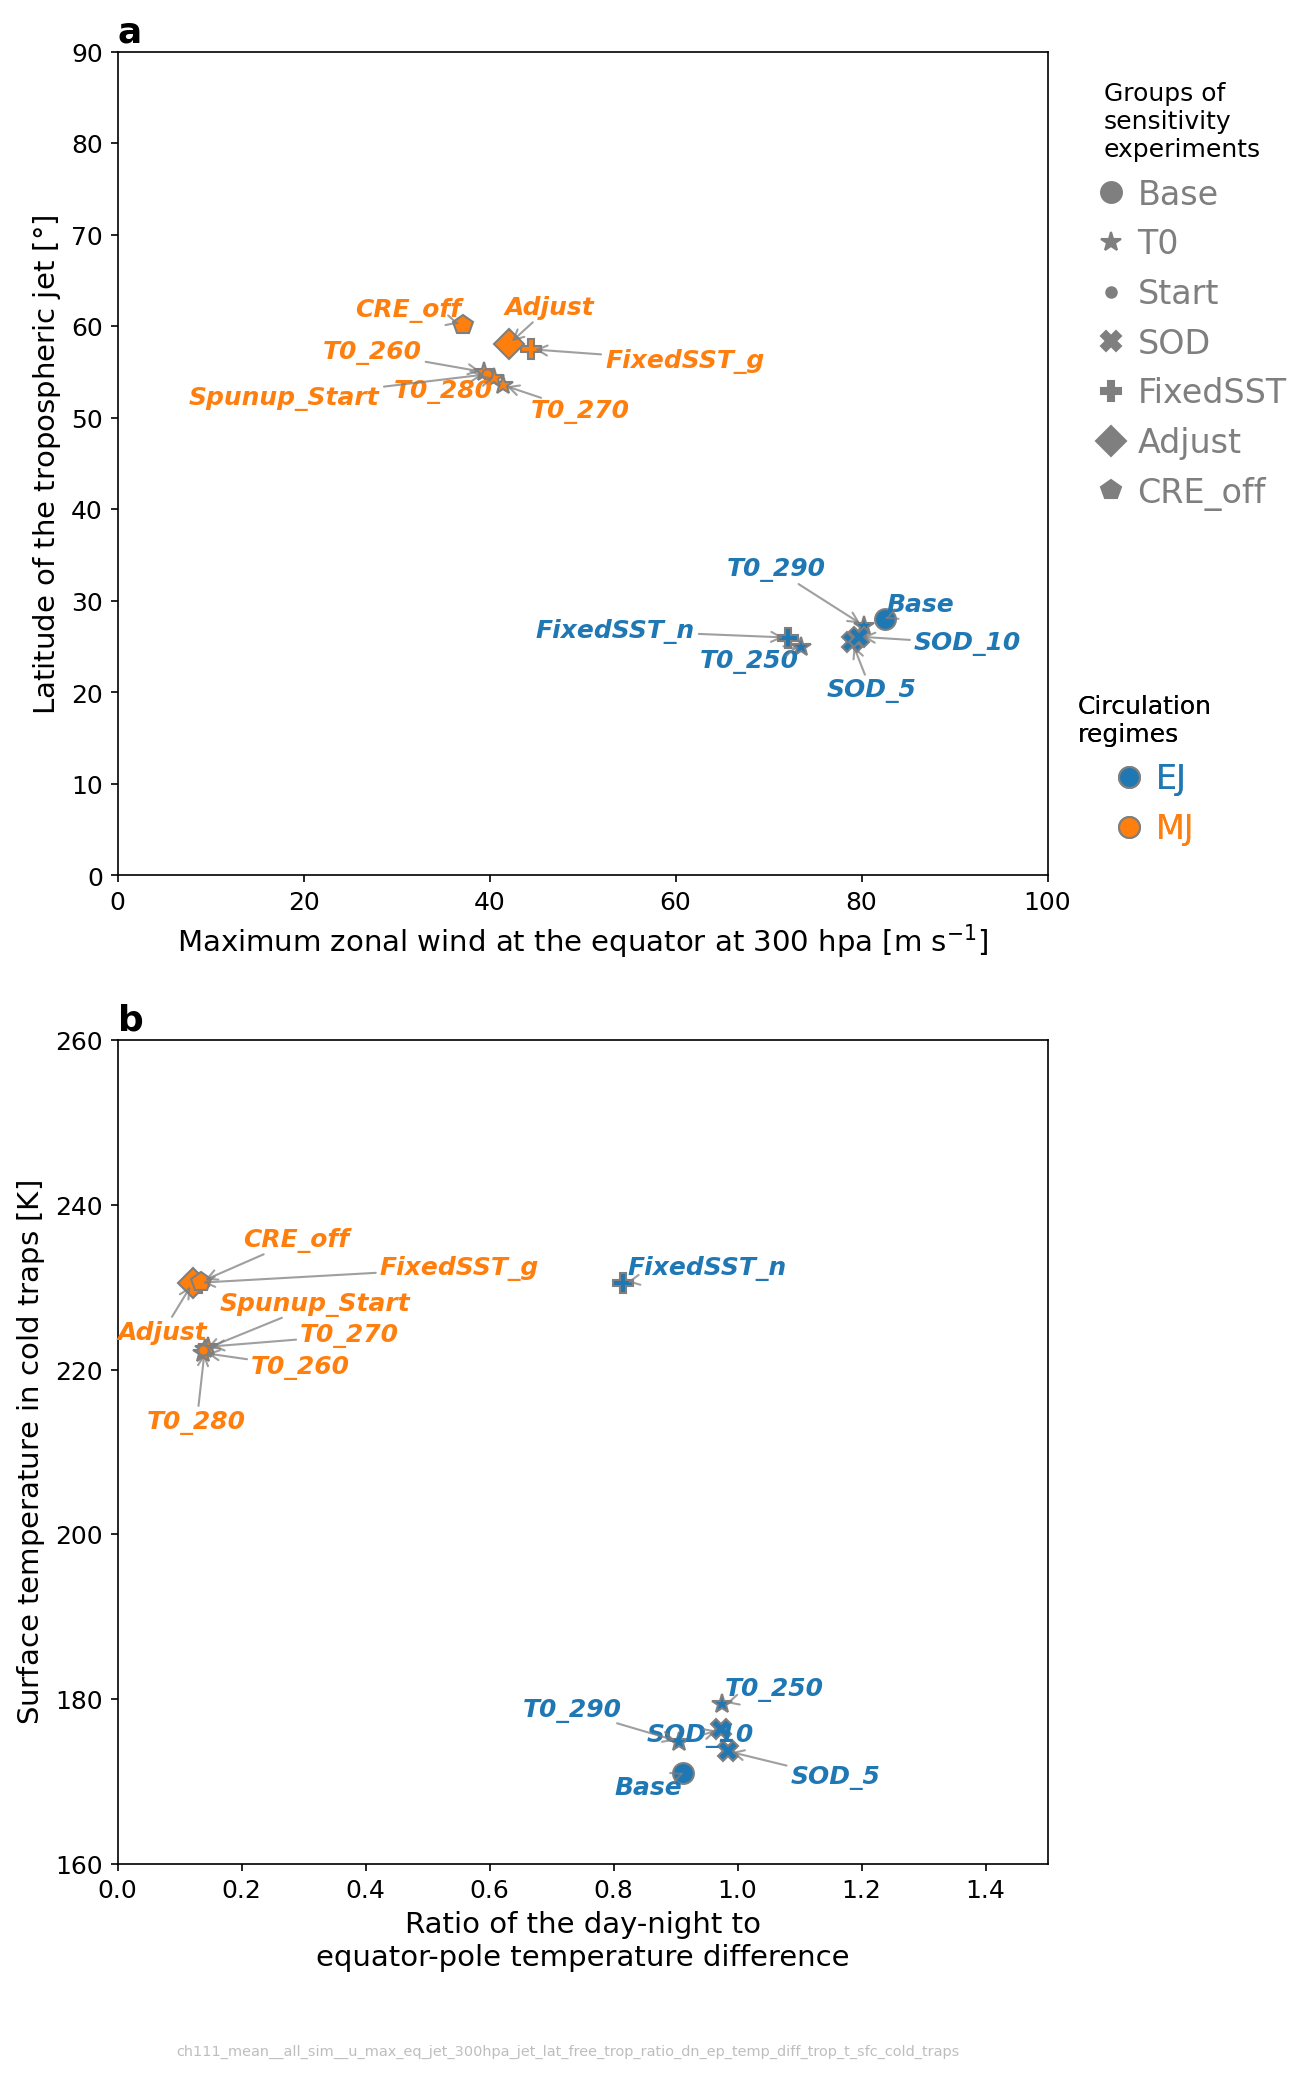

In [113]:
# for vrbl_key_x, vrbl_key_y in tqdm(itertools.combinations(VRBL_PLOT.keys(), 2)):
# {'_'.join([i.replace('sens-','') for i in OPT_LABELS.keys()])}
imgname = f"{img_prefix}__all_sim__{'_'.join([i for j in vrbl_pairs for i in j])}"
kw_plt_common = {"linewidth": 0, "ms": 10, "mec": "tab:grey"}
fig = plt.figure(figsize=(8, 16))
axd = fig.subplot_mosaic([["-".join(i)] for i in vrbl_pairs])
iletters = subplot_label_generator()
for vrbl_key_x, vrbl_key_y in vrbl_pairs:
    ax = axd[f"{vrbl_key_x}-{vrbl_key_y}"]
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    xlabel = VRBL_PLOT[vrbl_key_x]["title"]
    if (units_x := VRBL_PLOT[vrbl_key_x]["tex_units"]) != "1":
        xlabel += f" [{units_x}]"
    ylabel = VRBL_PLOT[vrbl_key_y]["title"]
    if (units_y := VRBL_PLOT[vrbl_key_y]["tex_units"]) != "1":
        ylabel += f" [{units_y}]"

    ax.set(
        xlim=VRBL_PLOT[vrbl_key_x].get("lim"),
        xlabel=xlabel,
        xscale=VRBL_PLOT[vrbl_key_x].get("scale", "linear"),
        ylim=VRBL_PLOT[vrbl_key_y].get("lim"),
        ylabel=ylabel,
        yscale=VRBL_PLOT[vrbl_key_y].get("scale", "linear"),
    )

    texts = []
    for sim_label, sim_prop in OPT_LABELS.items():
        kw_plt = KW_PLT_GROUPS[sim_prop.get("group", "base")]["kw_plt"]
        ax.plot(
            RESULTS[vrbl_key_x][sim_label].data,
            RESULTS[vrbl_key_y][sim_label].data,
            **kw_plt_common,
            **REGIMES[sim_prop["regime"]]["kw_plt"],
            **kw_plt,
        )
        texts.append(
            ax.text(
                RESULTS[vrbl_key_x][sim_label].data,
                RESULTS[vrbl_key_y][sim_label].data,
                sim_prop["title"],
                color=REGIMES[sim_prop["regime"]]["kw_plt"]["color"],
                fontstyle="italic",
                fontweight="bold",
            )
        )
    adjust_text(
        texts,
        ax=ax,
        force_text=(1.0, 1.0),
        arrowprops=dict(arrowstyle="->", color="tab:grey", alpha=0.75),
    )
    if ax.get_subplotspec().is_first_row():
        add_custom_legend(
            ax,
            {
                group_prop["title"]: {
                    "color": "tab:grey",
                    **kw_plt_common,
                    **group_prop["kw_plt"],
                }
                for _, group_prop in KW_PLT_GROUPS.items()
            },
            loc="upper left",
            bbox_to_anchor=(1.0, 1.0),
            frameon=False,
            ncol=1,
            title="Groups of\nsensitivity\nexperiments",
            handletextpad=-0.2,
        )
        add_custom_legend(
            ax,
            {
                name: {
                    "marker": "o",
                    **kw_plt_common,
                    **prop["kw_plt"],
                }
                for name, prop in REGIMES.items()
            },
            loc="lower left",
            bbox_to_anchor=(1.0, 0.0),
            frameon=False,
            ncol=1,
            title="Circulation\nregimes",
            handletextpad=-0.2,
        )

figsave(fig, plotdir / imgname)

### Maps of surface temperature in the sens-fixedsst experiment

In [25]:
chosen_opt_labels = ["sens-fixedsst", "sens-fixedsst-day-night"]

216.12091064453125 293.79986572265625
189.56198120117188 287.4574279785156
170.6182403564453 287.4574279785156
170.6182403564453 293.79986572265625
Saved to ../../plots/sa/ch111/ch111_mean/ch111_mean__grcs_llcs__sens-fixedsst_sens-fixedsst-day-night__t_sfc_300hpa_winds.png


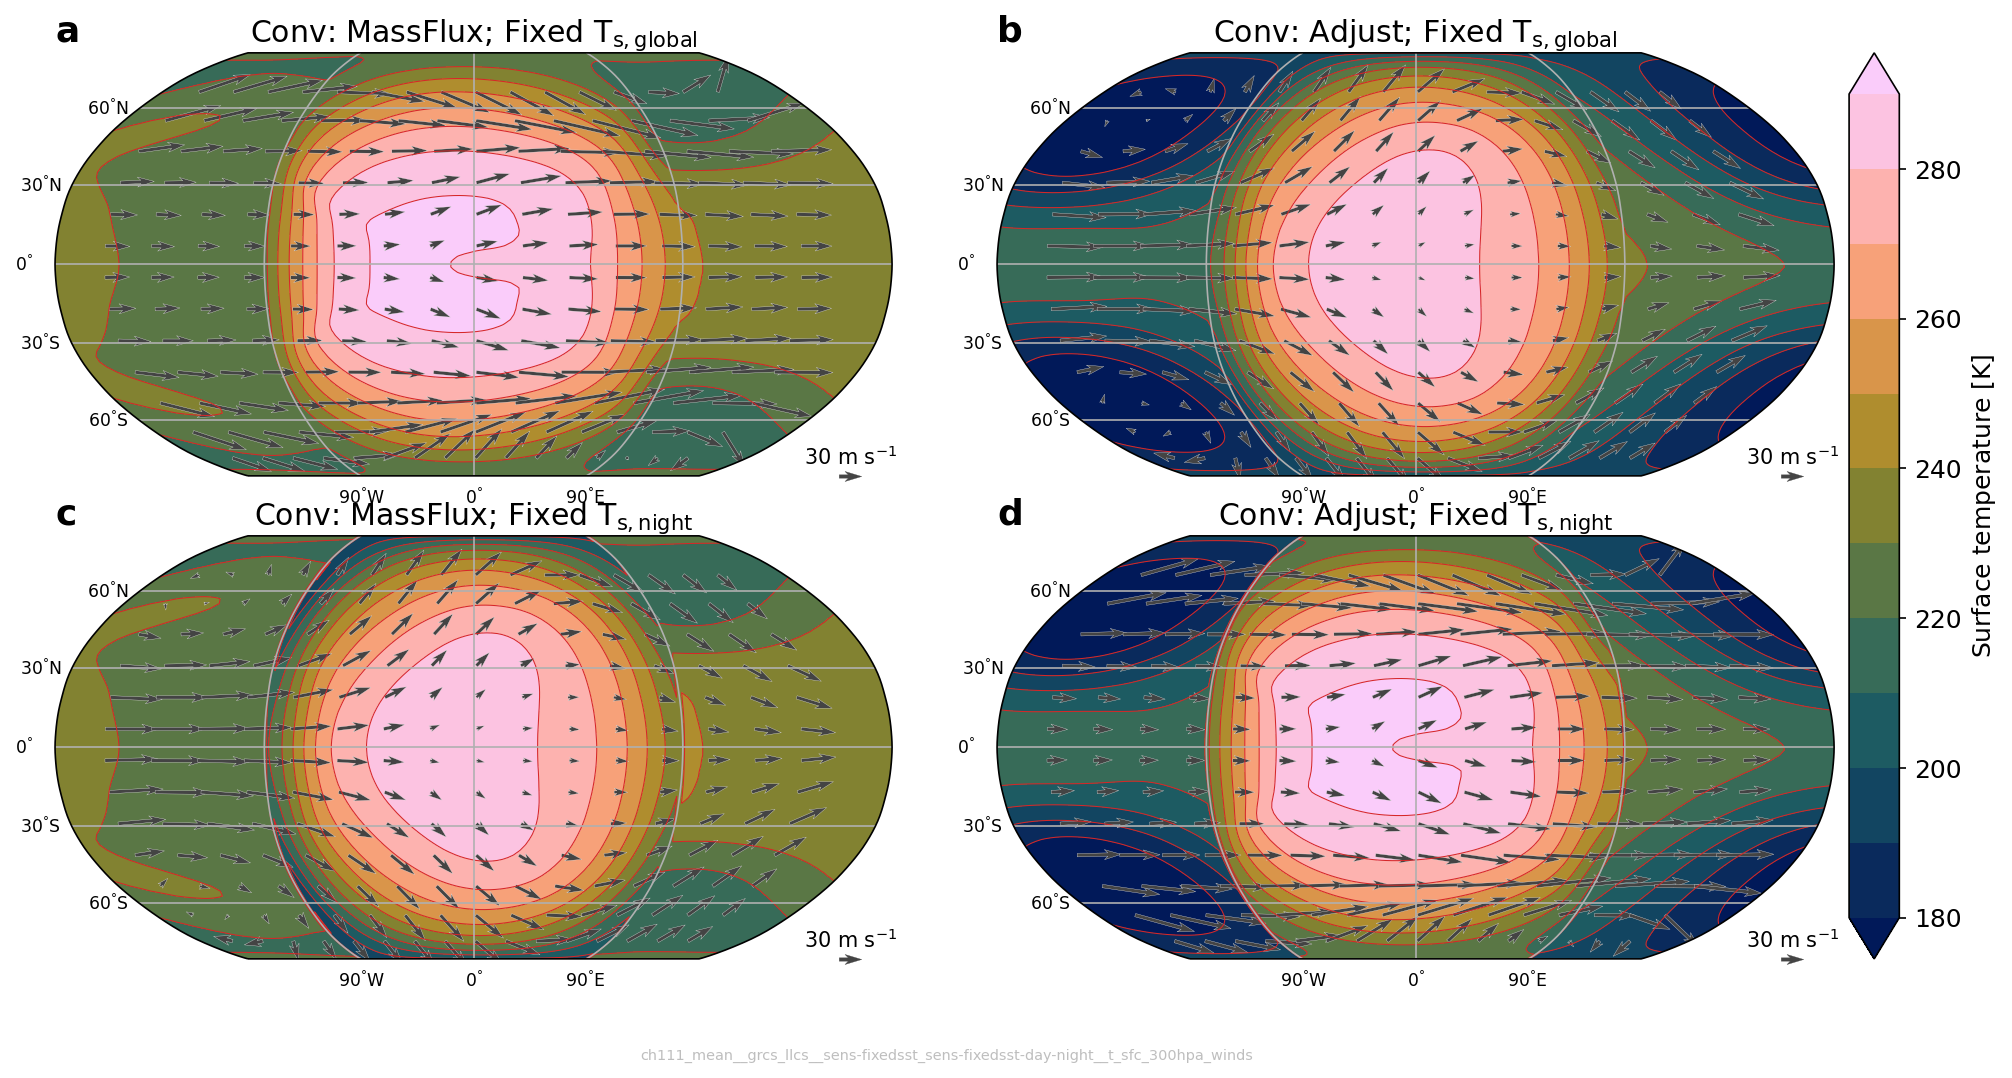

In [62]:
imgname = f"{img_prefix}__{'_'.join(chosen_opt_labels)}__t_sfc_{P_LEV1}hpa_winds"

fig, axgr = make_map_figure(2, 2, **KW_AXGR)
cax = axgr.cbar_axes[0]
axs = np.array(axgr.axes_column)

iletters = subplot_label_generator()
for ax in axs.T.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)

for (suite_label, suite_prop), axcol in zip(SUITE_LABELS.items(), axs):
    for opt_label, ax in zip(chosen_opt_labels, axcol):
        ax.set_title(
            f'{suite_prop["title"]}; {OPT_LABELS[opt_label]["title"]}', **KW_MAIN_TTL
        )
        sim_label = f"{suite_label}_{opt_label}"
        the_run = runs[sim_label]
        the_run_p = runs_p[sim_label]

        t_sfc_map = time_mean(the_run.t_sfc)
        print(t_sfc_map.data.min(), t_sfc_map.data.max())
        u_map = time_mean(the_run_p.u.extract(p_lev_constr1))
        v_map = time_mean(the_run_p.v.extract(p_lev_constr1))

        p0 = draw_scalar_cube(
            t_sfc_map,
            ax,
            method="contourf",
            cmap=cm.batlow,
            cax=cax,
            levels=np.arange(180, 291, 10),
            extend="both",
        )
        draw_scalar_cube(
            t_sfc_map,
            ax,
            method="contour",
            colors="tab:red",
            levels=np.arange(180, 291, 10),
            linewidths=0.5,
        )
        draw_vector_cubes(
            u_map,
            v_map,
            ax,
            xstride=8,
            ystride=6,
            qk_ref_wspd=30,
            kw_quiver={**KW_QUIVER, **KW_CART},
            kw_quiverkey=KW_QUIVERKEY,
            quiverkey_xy=(0.95, 0.00),
        )


cax.set_ylabel("Surface temperature [$K$]", **KW_CBAR_TTL)
figsave(fig, plotdir / imgname)